In [1]:
import pandas as pd
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from src.generate_ode import ode_gen_qcrispri, ode_gen_qcrispri_simple, ode_gen_qcrispri_sponge, ode_gen_quorum
from src.calculate_metrics import CalculateDynamicsMetrics
from src.solve_ode import solve_qcrispri, solve_qcrispri_simple, solve_qcrispri_sponge, solve_quorum, t, alpha0, kd1, kd2
from src.plots import vertical_stack_plot_3, plot_2param_vary
from src.sensitivity_analysis import vary_two_parameter,vary_single_parameter, vary_decoysite, get_default_param_value


Base Model equations

\begin{equation}
P0 ---\alpha0---> P0 + n_A*A + n_G*G \\
P1 ---\alpha_I---> P1 + n_A*A + n_G*G  \\
P_T ----\alpha_R---> P_T + R \\
2R + 2A <----^{k1R}--_{kd1}---> R*  \\
R* + P0 <-----^{k2R}---_{kd2}---> P1 \\
R, A, G ---d_R, d_A, d_G----> \emptyset
\end{equation}

# Model Simulations

### Simulate Quorum sensing system using the model fit parameters

In [2]:
base_df = solve_quorum()
#Plot GFP vs Time for "BASE MODEL"
fig = px.line(x = t, y = base_df.GFP, labels={'x':'Time (hr)', 'y':'GFP (AU)'})
fig.show()

### Model fit the qCRISPRI system with experimental data

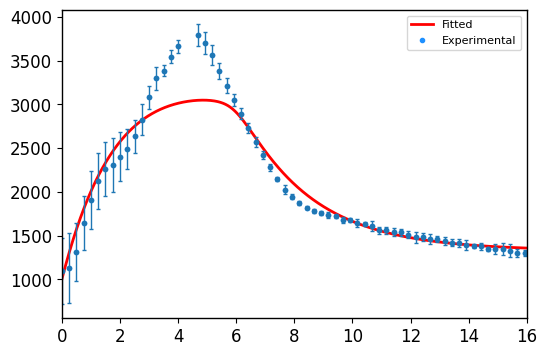

In [3]:
#import experimental data 
data = pd.read_excel('./data/qCRISPRi_wildVSmutant_130221_cleaned.xlsx')
#simulate qcrispri dynamics
qcrispri_df = solve_qcrispri(activity_ratio= 0.1)


#Plot GFP vs Time for "qCRISPRi MODEL"
fig, ax = plt.subplots(figsize = (6,4))
plt.plot(t, qcrispri_df.GFP, linewidth = 2, color = 'red', label = 'Fitted')
plt.plot(data.time, data.avgwildgfp, '.', label = 'Experimental', color = 'dodgerblue')
plt.errorbar(data.time, data.avgwildgfp_dcas9_df_dcas9_df_dcas9_df_dcas9_df_dcas9_df_dcas9_df, yerr=data.stdwildgfp, fmt=".", elinewidth = 1, capsize=1.2)
ax.set_xlim(0,16)
for i in ['right', 'left', 'top', 'bottom']:
    ax.spines[i].set(linewidth = 1)
#ax.set_xlabel('Time (hr)', fontsize = 12)
#ax.set_ylabel('GFP Fluorescence [au]',  fontsize = 12)
ax.legend(prop={"size":8}, loc = 'upper right')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.rc('legend', fontsize=8)
plt.legend()
plt.show()
#fig.savefig('Figures\Model-fit.png', dpi=256, bbox_inches = "tight")




### qCRISPRi Decoy Model

In [7]:
qcrispri_decoy = solve_qcrispri_sponge()
qcrispri_wild = solve_qcrispri()

#Plot GFP vs Time for "qCRISPRi decoy MODEL"
fig = go.Figure()
fig.add_trace(go.Scatter(x = t, y = qcrispri_decoy.GFPc, name = 'Control GFP'))
fig.add_trace(go.Scatter(x = t, y = qcrispri_wild.GFP, name = 'qCRISPRI:Wild'))
fig.add_trace(go.Scatter(x = t , y = qcrispri_decoy.GFP, name = 'qCRISPRi:Decoy'))
fig.show()

# Sensitivity Analysis: One Parameter at Once
Analze how changing leaky expression rate of dCas9 promoter(luxI), dissociation constant between DNA and LuxR:AHL compelx (kd2), and dissociation constant between AHL and LuxR(kd1) affects circuit parameters. All these 3 parameters were changed one at a time and the change in circuit parameters switching density, fold repression and transition time were calculated. 

In [2]:
#define ranges for the parameters
alphaT_range = [0, round(alpha0*0.5, 1), alpha0, round(alpha0*1.5, 1), round(alpha0*2, 1)]
Kd1_range = [kd1*0.25, kd1*0.5, kd1, kd1*1.5, kd1*1.75]
Kd2_range = [kd2*0.25, kd2*0.5, kd2, kd2*1.5, kd2*1.75]

## Basal expression / leakiness

/Users/saiakhilgolla/Library/CloudStorage/OneDrive-Personal/Akhil/University/UofT- Masters/Quorum_Switch/src/sensitivity_analysis.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gfp_df = pd.concat([gfp_df, temp])
/Users/saiakhilgolla/Library/CloudStorage/OneDrive-Personal/Akhil/University/UofT- Masters/Quorum_Switch/src/sensitivity_analysis.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metric_df = pd.concat([metric_df, pd.DataFrame([new_row])], ignore_index = True)
/Users/saiakhilgol

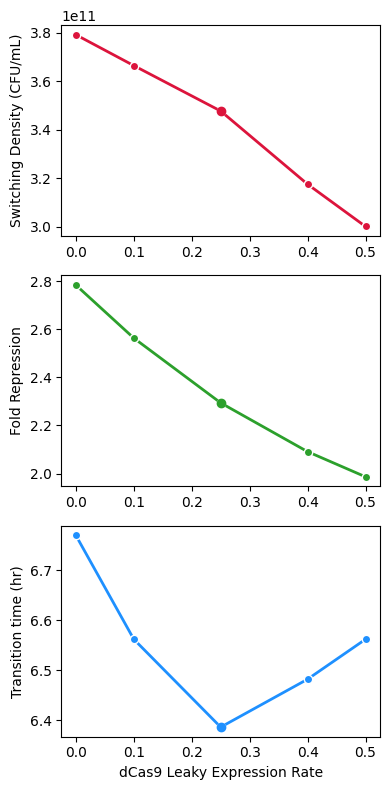

In [3]:
#simulating qcrispri dynamics with varying leaky expression rates and calculating metrics: switching density, fold repression, and transition time

gfp_leaky, metrics_leaky = vary_single_parameter("alphaT", alphaT_range )
fig = vertical_stack_plot_3('alphaT', alphaT_range, metrics_leaky.switching_density, metrics_leaky.fold_repression, metrics_leaky.transition_time, 'dCas9 Leaky Expression Rate')

### Concentration of dCas9 bound promoter in leaky vs non leaky system

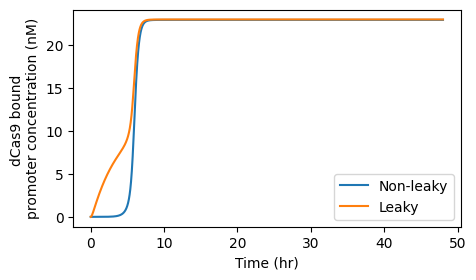

In [4]:
qcrispri_nonleaky = solve_qcrispri(alphaT = 0)
qcrispri_leaky = solve_qcrispri()

fig, ax = plt.subplots(figsize=(5,2.82))
ax.plot(t, qcrispri_nonleaky.pD, label = "Non-leaky")
ax.plot(t, qcrispri_leaky.pD, label = 'Leaky' )
plt.ylabel('dCas9 bound \npromoter concentration (nM)')
plt.xlabel('Time (hr)')
plt.legend()
plt.show()
#fig.savefig('Figures\leaky_vs_non_leaky_dCas9_bound_promoter', dpi = 386, bbox_inches = 'tight')

### dynamics of qcrispri when leakiness of dCas9 expressing promoter is varied

In [6]:
### dynamics of changing leakiness
x = t
fig = go.Figure()

for i in [0, alpha0, round(alpha0*1.5, 1)]:
    #x = gfp_leaky[gfp_leaky["alphaT_value"] == i].N
    y = gfp_leaky[gfp_leaky["alphaT_value"] == i].GFP
    fig.add_trace(go.Scatter(x = t, y = y, name = i))
yc = gfp_leaky[gfp_leaky["alphaT_value"] == 0].control
fig.add_trace(go.Scatter(x = t, y = yc, name = 'Control' ))

fig.update_layout( xaxis_title='Time (hr)', yaxis_title='GFP [AU]')
fig.update_layout(font=dict(size=20))
fig.update_layout(legend=dict(yanchor="top",y=0.90,xanchor="right",x=0.99,bgcolor="rgba(0,0,0,0)", bordercolor="Black",
        borderwidth=1))
fig.update_layout({'paper_bgcolor':'rgba(0,0,0,0)','plot_bgcolor':'rgba(0,0,0,0)'})
fig.update_xaxes(showgrid=False, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showgrid=False, linewidth=2, linecolor='black', mirror=True)
fig.update_layout(font_family="Verdana", font_color="black")
fig.update_xaxes(ticks="outside",tickson="boundaries",ticklen=5)
fig.update_yaxes(ticks="outside",tickson="boundaries",ticklen=5)
fig.show()

## Dissociation constant of LuxR_AHL complex (Kd1)

/Users/saiakhilgolla/Library/CloudStorage/OneDrive-Personal/Akhil/University/UofT- Masters/Quorum_Switch/src/sensitivity_analysis.py:33: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

/Users/saiakhilgolla/Library/CloudStorage/OneDrive-Personal/Akhil/University/UofT- Masters/Quorum_Switch/src/sensitivity_analysis.py:38: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

/Users/saiakhilgolla/Library/CloudStorage/OneDrive-Personal/Akhil/University/UofT- Masters/Quorum_Switch/src/plots.py:19: UserWarning:

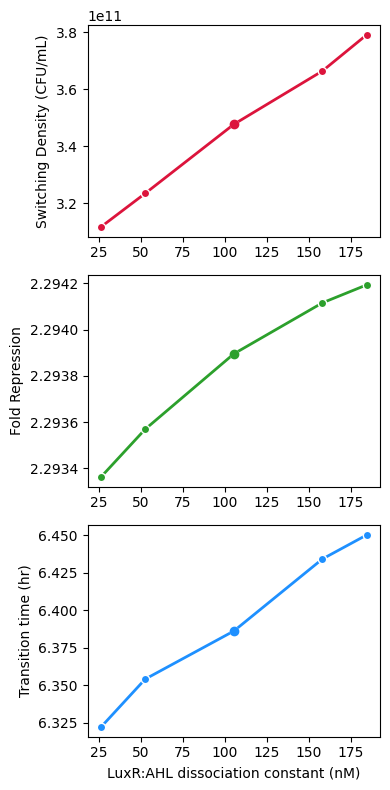

In [7]:
#simulating qcrispri dynamics with varying dissociation constant of LuxR_AHL complex and calculating 
#parameters switching density, fold repression, and transition time
Kd1_range = [kd1*0.25, kd1*0.5, kd1, kd1*1.5, kd1*1.75]
gfp_kd1, metrics_kd1 = vary_single_parameter("Kd1", Kd1_range )
fig = vertical_stack_plot_3('Kd1', Kd1_range, metrics_kd1.switching_density,metrics_kd1.fold_repression, metrics_kd1.transition_time, 'LuxR:AHL dissociation constant (nM)')


### concentration of LuxR:AHL complex

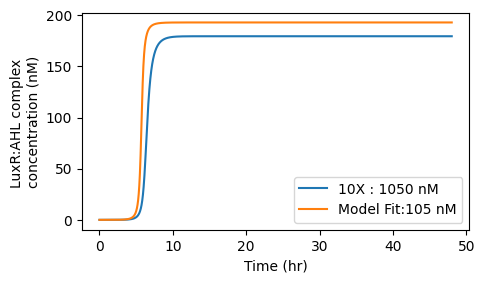

In [8]:
wild_kd1 = solve_qcrispri()
high_kd1 = solve_qcrispri(Kd1= kd1*10)


fig, ax = plt.subplots(figsize=(5,2.82))
ax.plot(t, high_kd1.LuxR_A, label = "10X : 1050 nM")
ax.plot(t, wild_kd1.LuxR_A, label = 'Model Fit:105 nM' )
plt.ylabel('LuxR:AHL complex \nconcentration (nM)')
plt.xlabel('Time (hr)')
plt.legend()
plt.show()
#fig.savefig('Figures/kd1vary_LuxR_A_dynamics', dpi = 386, bbox_inches = 'tight')

### Dynamics of qcrispri system when Kd1 was varied

In [9]:
### dynamics of changing dissociation constant for luxR_AHL complex
x = t
fig = go.Figure()

for i in [kd1*0.25, kd1, kd1*1.75]:
    #x = gfp_kd1[gfp_kdna["kd1lex"] == i].N
    y = gfp_kd1[gfp_kd1["Kd1_value"] == i].GFP
    fig.add_trace(go.Scatter(x = t, y = y, name = '{}'.format(i)))
fig.update_layout( xaxis_title='Time (hr)', yaxis_title='GFP [AU]')
fig.update_layout(font=dict(size=20))
fig.update_layout(legend=dict(yanchor="top",y=0.90,xanchor="right",x=0.99,bgcolor="rgba(0,0,0,0)", bordercolor="Black",
        borderwidth=1))
fig.update_layout({'paper_bgcolor':'rgba(0,0,0,0)','plot_bgcolor':'rgba(0,0,0,0)'})
fig.update_xaxes(showgrid=False, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showgrid=False, linewidth=2, linecolor='black', mirror=True)
fig.update_layout(font_family="Verdana", font_color="black")
fig.update_xaxes(ticks="outside",tickson="boundaries",ticklen=5)
fig.update_yaxes(ticks="outside",tickson="boundaries",ticklen=5)

fig.show()

## Dissociation constant for LuxR_AHL complex and DNA (Kd2)

/Users/saiakhilgolla/Library/CloudStorage/OneDrive-Personal/Akhil/University/UofT- Masters/Quorum_Switch/src/sensitivity_analysis.py:33: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

/Users/saiakhilgolla/Library/CloudStorage/OneDrive-Personal/Akhil/University/UofT- Masters/Quorum_Switch/src/sensitivity_analysis.py:38: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

/Users/saiakhilgolla/Library/CloudStorage/OneDrive-Personal/Akhil/University/UofT- Masters/Quorum_Switch/src/plots.py:19: UserWarning:

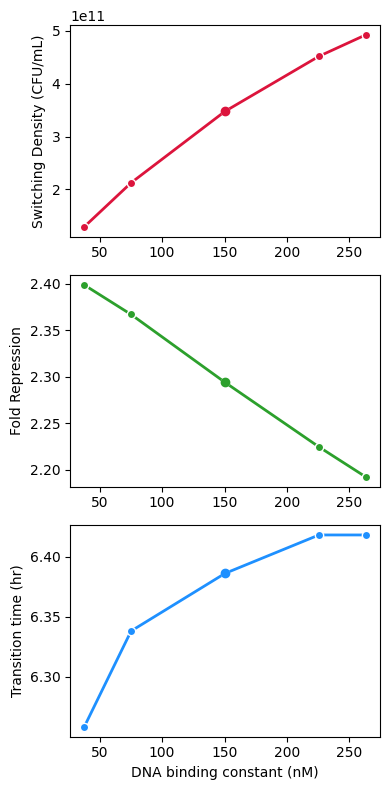

In [10]:
#simulating qcrispri dynamics with varying dissociation constant for LuxR_AHL complex and calculating 
#parameters switching density, fold repression, and transition time
Kd2_range = [kd2*0.25, kd2*0.5, kd2, kd2*1.5, kd2*1.75]
gfp_kd2, metrics_kd2 = vary_single_parameter("Kd2", Kd2_range )
fig = vertical_stack_plot_3('Kd2', Kd2_range, metrics_kd2.switching_density, metrics_kd2.fold_repression, metrics_kd2.transition_time, 'DNA binding constant (nM)')

### Max GFP of the system when Kd2 was set to model fit parameter vs 1.75*model fit parameter

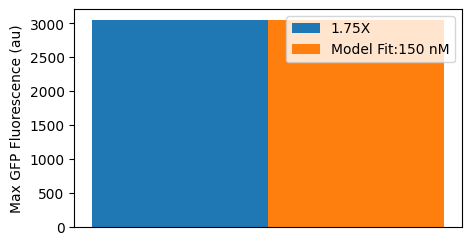

In [12]:
wild_kd2 = solve_qcrispri()
high_kd2 = solve_qcrispri(Kd2= kd2*1.75)

width=0.1
fig, ax = plt.subplots(figsize=(5,2.82))
ax.bar( 0, max(high_kd2.GFP), width, label = "1.75X")
ax.bar(0+ width, max(wild_kd2.GFP), width, label = 'Model Fit:150 nM' )
plt.ylabel('Max GFP Fluorescence (au)')
ax.tick_metrics(bottom = False)
ax.set_xticklabels(labels = '')
plt.legend()
plt.show()
#fig.savefig('Figures\kd2vary_MaxGFP', dpi = 386, bbox_inches = 'tight')

### Dynamics of the qcrispri system when Kd2 is varied.

In [11]:
### dynamics of changing dissociation constant for luxR_AHL complex
x = t
fig = go.Figure()

for i in [kd2*0.25, kd2, kd2*1.75]:
    #x = gfp_kd2[gfp_kd2["kd2_bind"] == i].N
    y = gfp_kd2[gfp_kd2["Kd2_value"] == i].GFP
    fig.add_trace(go.Scatter(x = t, y = y, name = 'Kd2 = {}'.format(i)))
fig.update_layout( xaxis_title='Time (hr)', yaxis_title='GFP [AU]')
fig.update_layout(font=dict(size=20))
fig.update_layout(legend=dict(yanchor="top",y=0.90,xanchor="right",x=0.99,bgcolor="rgba(0,0,0,0)", bordercolor="Black",
        borderwidth=1))
fig.update_layout({'paper_bgcolor':'rgba(0,0,0,0)','plot_bgcolor':'rgba(0,0,0,0)'})
fig.update_xaxes(showgrid=False, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showgrid=False, linewidth=2, linecolor='black', mirror=True)
fig.update_layout(font_family="Verdana", font_color="black")
fig.update_xaxes(ticks="outside",tickson="boundaries",ticklen=5)
fig.update_yaxes(ticks="outside",tickson="boundaries",ticklen=5)
fig.show()

## Compiled figure for sensitivity of the dynamics metrics to different parameters 

In [13]:
density = pd.concat([metrics_leaky.switching_density,metrics_kd1.switching_density, metrics_kd2.switching_density]) 
fold = pd.concat([metrics_leaky.fold_repression,metrics_kd1.fold_repression, metrics_kd2.fold_repression]) 
time = pd.concat([metrics_leaky.transition_time,metrics_kd1.transition_time, metrics_kd2.transition_time])
min_density = min(density)
max_density = max(density)
min_fold = min(fold)
max_fold = max(fold)
min_time = min(time)
max_time = max(time)

/var/folders/bf/wlmhvvbx0n768cmc2p56f27m0000gn/T/ipykernel_41248/2326733657.py:2: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "C1o-" (-> color=(1.0, 0.4980392156862745, 0.054901960784313725, 1.0)). The keyword argument will take precedence.

/var/folders/bf/wlmhvvbx0n768cmc2p56f27m0000gn/T/ipykernel_41248/2326733657.py:7: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "C1o-" (-> color=(1.0, 0.4980392156862745, 0.054901960784313725, 1.0)). The keyword argument will take precedence.

/var/folders/bf/wlmhvvbx0n768cmc2p56f27m0000gn/T/ipykernel_41248/2326733657.py:12: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "C1o-" (-> color=(1.0, 0.4980392156862745, 0.054901960784313725, 1.0)). The keyword argument will take precedence.

/var/folders/bf/wlmhvvbx0n768cmc2p56f27m0000gn/T/ipykernel_41248/2326733657.py:18: UserWarning:

color is redundantly defin

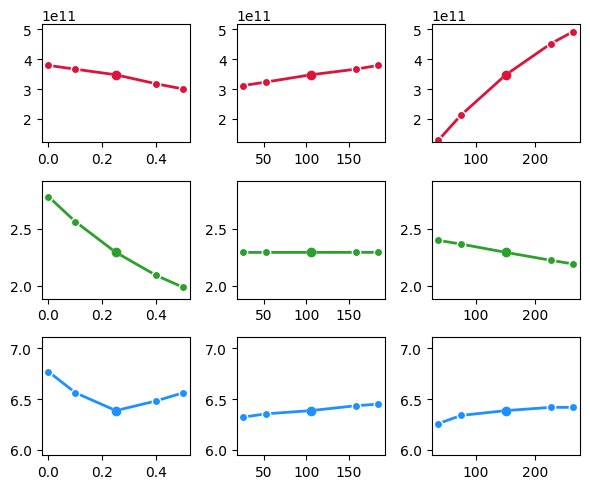

In [15]:
fig, ((ax1, ax2, ax3),(ax4, ax5, ax6),(ax7, ax8, ax9) ) = plt.subplots(3,3, figsize =(6,5))
ax1.plot(metrics_leaky.alphaT_value, metrics_leaky.switching_density, "C1o-", mec = '1.0', color = 'crimson', linewidth = 2)
ax1.plot(alpha0, metrics_leaky.switching_density.iloc[2], marker = "o", color = 'crimson')
ax1.set_ylim(0.95*min_density, 1.05*max_density)
#ax1.set_ylabel('Switching Density\n(CFU/mL)', fontsize = 8)

ax2.plot(metrics_kd1.Kd1_value, metrics_kd1.switching_density, "C1o-", mec = '1.0', color = 'crimson', linewidth = 2)
ax2.plot(kd1, metrics_kd1.switching_density.iloc[2], marker = "o", color = 'crimson')
ax2.set_ylim(0.95*min_density, 1.05*max_density)
#ax2.set_ylabel('Switching Density (CFU/mL)')

ax3.plot(metrics_kd2.Kd2_value, metrics_kd2.switching_density, "C1o-", mec = '1.0', color = 'crimson', linewidth = 2)
ax3.plot(kd2, metrics_kd2.switching_density.iloc[2], marker = "o", color = 'crimson')
ax3.set_ylim(0.95*min_density, 1.05*max_density)
#ax3.set_ylabel('Switching Density (CFU/mL)')


ax4.plot(metrics_leaky.alphaT_value, metrics_leaky.fold_repression, "C1o-", mec = '1.0', color = 'C2', linewidth = 2)
ax4.plot(alpha0, metrics_leaky.fold_repression.iloc[2], marker = "o", color = 'C2')
ax4.set_ylim(0.95*min_fold, 1.05*max_fold)
#ax4.set_ylabel('Fold Repression', fontsize = 8)

ax5.plot(metrics_kd1.Kd1_value, metrics_kd1.fold_repression, "C1o-", mec = '1.0', color = 'C2', linewidth = 2)
ax5.plot(kd1, metrics_kd1.fold_repression.iloc[2], marker = "o", color = 'C2')
ax5.set_ylim(0.95*min_fold, 1.05*max_fold)
#ax5.set_ylabel('Fold Repression')

ax6.plot(metrics_kd2.Kd2_value, metrics_kd2.fold_repression, "C1o-", mec = '1.0', color = 'C2', linewidth = 2)
ax6.plot(kd2, metrics_kd2.fold_repression.iloc[2], marker = "o", color = 'C2')
ax6.set_ylim(0.95*min_fold, 1.05*max_fold)
#ax6.set_ylabel('Fold Repression')

ax7. plot(metrics_leaky.alphaT_value, metrics_leaky.transition_time, "C1o-", mec = '1.0', color = 'dodgerblue', linewidth = 2)
ax7.plot(alpha0, metrics_leaky.transition_time.iloc[2], marker = "o", color = 'dodgerblue')
#ax7.set_xlabel('dCas9 Leaky Expression', fontsize = 8)
ax7.set_ylim(0.95*min_time, 1.05*max_time)
#ax7.set_ylabel('Transition time (hr)', fontsize = 8)

ax8. plot(metrics_kd1.Kd1_value, metrics_kd1.transition_time, "C1o-", mec = '1.0', color = 'dodgerblue', linewidth = 2)
ax8.plot(kd1, metrics_kd1.transition_time.iloc[2], marker = "o", color = 'dodgerblue')
#ax8.set_xlabel('LuxR:AHL complex dissociation constasnt', fontsize = 8)
ax8.set_ylim(0.95*min_time, 1.05*max_time)
#ax8.set_ylabel('Transition time (hr)')

ax9. plot(metrics_kd2.Kd2_value, metrics_kd2.transition_time, "C1o-", mec = '1.0', color = 'dodgerblue', linewidth = 2)
ax9.plot(kd2, metrics_kd2.transition_time.iloc[2], marker = "o", color = 'dodgerblue')
#ax9.set_xlabel('DNA binding conatant (nM)', fontsize = 8)
ax9.set_ylim(0.95*min_time, 1.05*max_time)
#ax9.set_ylabel('Transition time (hr)')

fig.tight_layout()
fig.show()
#fig.savefig('Figures\singleSensi_param.png', dpi=300)

## compiled figure showing variation in dynamics of the system when each parameter is increased/decreased

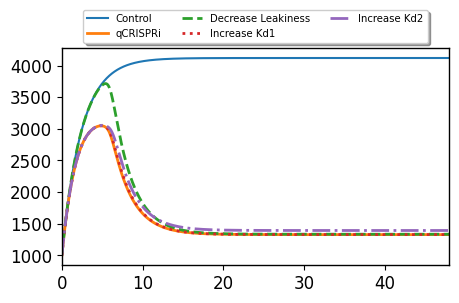

In [16]:
cmap = plt.get_cmap("tab10")
colors = cmap.colors
fig, ax = plt.subplots(figsize = (5,2.82))
plt.plot(t, gfp_leaky[gfp_leaky["alphaT_value"] == 0].control, linewidth = 1.5, label='Control', color = colors[0]) 
plt.plot(t, gfp_leaky[gfp_leaky["alphaT_value"] == alpha0].GFP, linewidth = 2, label='qCRISPRi', color = colors[1])
plt.plot(t, gfp_leaky[gfp_leaky["alphaT_value"] == 0].GFP, linewidth = 2, linestyle = '--', label='Decrease Leakiness', color = colors[2])  
plt.plot(t, gfp_kd1[gfp_kd1["Kd1_value"] == 1.75*kd1].GFP, linewidth = 2, linestyle = ':', label='Increase Kd1', color = colors[3])
plt.plot(t, gfp_kd2[gfp_kd2["Kd2_value"] == 1.75*kd2].GFP, linewidth = 2, linestyle = '-.', label='Increase Kd2', color = colors[4])
ax.set_xlim(0,48)
for i in ['right', 'left', 'top', 'bottom']:
    ax.spines[i].set(linewidth = 1)
#ax.set_xlabel('Time (hr)', fontsize = 12)
#ax.set_ylabel('GFP Fluorescence [au]',  fontsize = 12)
ax.legend(prop={"size":8}, loc = 'upper right')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.rc('legend', fontsize=8)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
          ncol=3, fancybox=True, shadow=True,prop={'size': 7.25})
#fig.savefig('Figures\singleSensi_dynamics.png', dpi=356, bbox_inches = "tight")

# Sensitiviy Analysis: 2 Parameters at once

### Varying leakiness + dCas9 repression strength

/Users/saiakhilgolla/Library/CloudStorage/OneDrive-Personal/Akhil/University/UofT- Masters/Quorum_Switch/src/sensitivity_analysis.py:70: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metric_df = pd.concat([metric_df, pd.DataFrame([new_row])], ignore_index = True)
/Users/saiakhilgolla/Library/CloudStorage/OneDrive-Personal/Akhil/University/UofT- Masters/Quorum_Switch/src/sensitivity_analysis.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gfp_df = pd.concat([gfp_df, temp])


Text(0, 0.5, '')

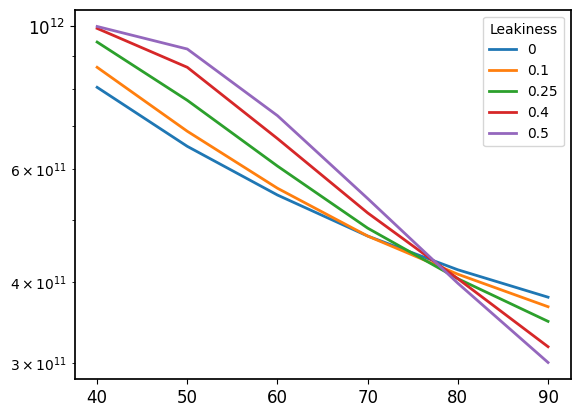

In [3]:
gfp_dcas9_df, metrics_dcas9_df = vary_two_parameter('alphaT', alphaT_range, 'activity_ratio', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6])

plot_2param_vary(metrics_dcas9_df, 'activity_ratio', 'switching_density', 'Repression Strength (%)', 'Switching Density (CFU/mL)')
#plt.xlim(0.1,0.7)
#plt.ylim(10**8, 6*10**8)
plt.yscale('log');
plt.gca().invert_xaxis()
plt.xticks([0.6, 0.5, 0.4, 0.3, 0.2, 0.1],[40, 50, 60, 70, 80, 90])
#for illustrator figure
plt.xlabel('')
plt.ylabel('')
#plt.gcf().set_size_inches(5, 2.82)
#plt.savefig('Figures\leaky_couples_sd_repr.png', dpi = 256, bbox_inches = 'tight')

([<matplotlib.axis.XTick at 0x1778e34d0>,
 [Text(0.6, 0, '40'),
  Text(0.5, 0, '50'),
  Text(0.4, 0, '60'),
  Text(0.3, 0, '70'),
  Text(0.2, 0, '80'),
  Text(0.1, 0, '90')])

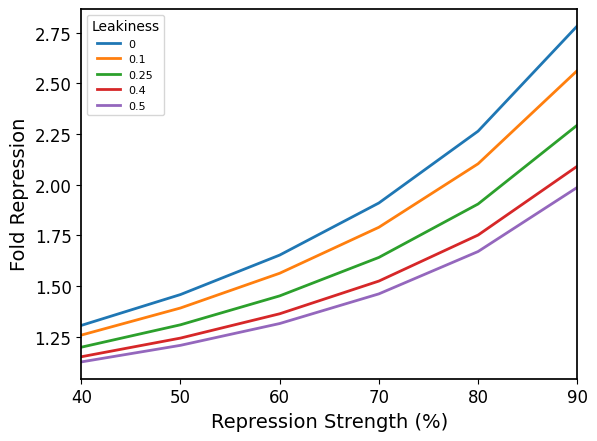

In [6]:
plot_2param_vary(metrics_dcas9_df, 'activity_ratio', 'fold_repression', 'Repression Strength (%)', 'Fold Repression')
plt.xlim(0.1,0.6)
plt.gca().invert_xaxis()
plt.xticks([0.6, 0.5, 0.4, 0.3, 0.2, 0.1],[40, 50, 60, 70, 80, 90])

([<matplotlib.axis.XTick at 0x1779074d0>,
 [Text(0.6, 0, '40'),
  Text(0.5, 0, '50'),
  Text(0.4, 0, '60'),
  Text(0.3, 0, '70'),
  Text(0.2, 0, '80'),
  Text(0.1, 0, '90')])

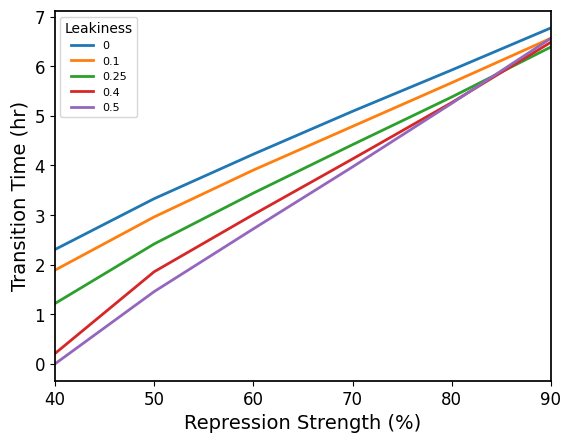

In [9]:
plot_2param_vary(metrics_dcas9_df, 'activity_ratio', 'transition_time', 'Repression Strength (%)', 'Transition Time (hr)')
plt.xlim(0.1,0.6)
#plt.ylim(1, 3)
plt.gca().invert_xaxis()
plt.xticks([0.6, 0.5, 0.4, 0.3, 0.2, 0.1],[40, 50, 60, 70, 80, 90])

### Varying  Leakiness + dissociation constant for LuxR:AHL complex

In [4]:
gfp_complex_df, metrics_complex_df = vary_two_parameter('alphaT', alphaT_range, 'Kd1', Kd1_range)

/Users/saiakhilgolla/Library/CloudStorage/OneDrive-Personal/Akhil/University/UofT- Masters/Quorum_Switch/src/sensitivity_analysis.py:70: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metric_df = pd.concat([metric_df, pd.DataFrame([new_row])], ignore_index = True)
/Users/saiakhilgolla/Library/CloudStorage/OneDrive-Personal/Akhil/University/UofT- Masters/Quorum_Switch/src/sensitivity_analysis.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gfp_df = pd.concat([gfp_df, temp])


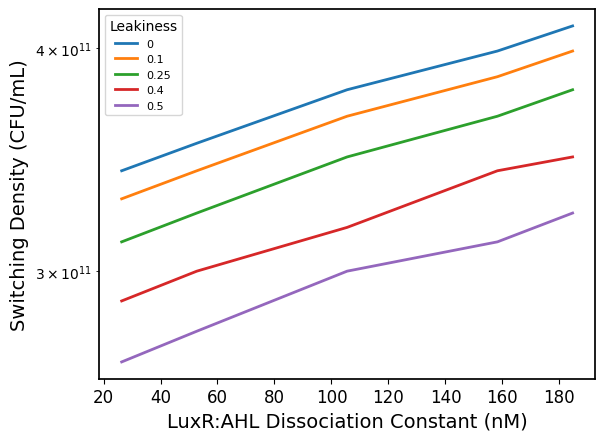

In [12]:
plot_2param_vary(metrics_complex_df, 'Kd1', 'switching_density', 'LuxR:AHL Dissociation Constant (nM)', 'Switching Density (CFU/mL)')
plt.yscale('log');

<module 'matplotlib.pyplot' from '/Users/saiakhilgolla/anaconda3/envs/metabolic_modeling/lib/python3.12/site-packages/matplotlib/pyplot.py'>

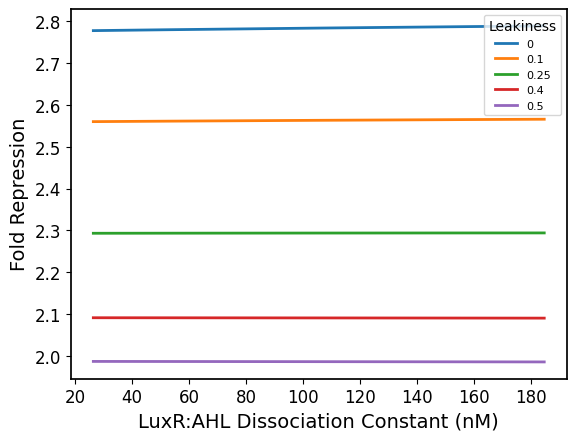

In [13]:
plot_2param_vary(metrics_complex_df, 'Kd1', 'fold_repression', 'LuxR:AHL Dissociation Constant (nM)', 'Fold Repression')

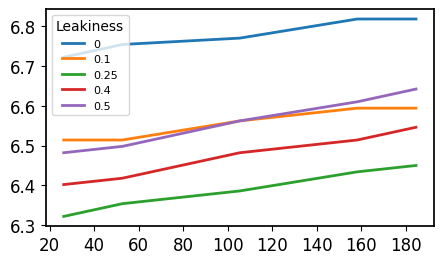

In [14]:
plot_2param_vary(metrics_complex_df, 'Kd1', 'transition_time', 'LuxR:AHL Dissociation Constant (nM)', 'Transition Time (hr)')
plt.xlabel('')
plt.ylabel('')
plt.gcf().set_size_inches(5, 2.82)
#plt.savefig('Figures\leaky_couples_tt_kcomp.png', dpi = 256, bbox_inches = 'tight')

### Varying Leakiness + dissociation constant of LuxR:AHL complex to DNA 

In [5]:
gfp_dna_df, metrics_dna_df = vary_two_parameter('alphaT', alphaT_range, 'Kd2', Kd2_range)

/Users/saiakhilgolla/Library/CloudStorage/OneDrive-Personal/Akhil/University/UofT- Masters/Quorum_Switch/src/sensitivity_analysis.py:70: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metric_df = pd.concat([metric_df, pd.DataFrame([new_row])], ignore_index = True)
/Users/saiakhilgolla/Library/CloudStorage/OneDrive-Personal/Akhil/University/UofT- Masters/Quorum_Switch/src/sensitivity_analysis.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gfp_df = pd.concat([gfp_df, temp])


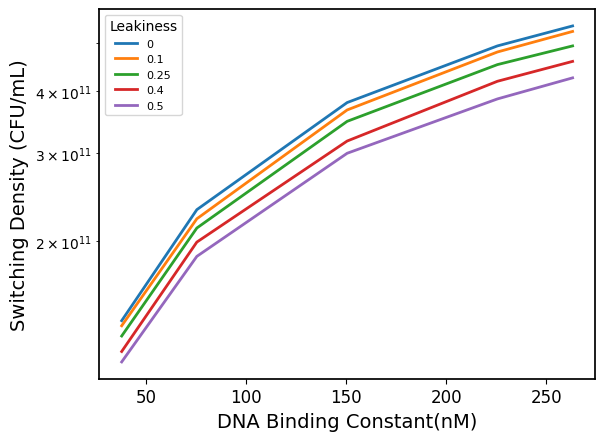

In [18]:
plot_2param_vary(metrics_dna_df, 'Kd2', 'switching_density', 'DNA Binding Constant(nM)', 'Switching Density (CFU/mL)')
plt.yscale('log');

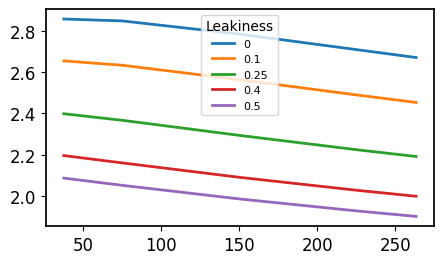

In [20]:
plot_2param_vary(metrics_dna_df, 'Kd2', 'fold_repression', 'DNA Binding Constant(nM)', 'Fold Repression')
plt.xlabel('')
plt.ylabel('')
plt.gcf().set_size_inches(5, 2.82)
#plt.savefig('Figures\leaky_couples_fr_Kd2.png', dpi = 256, bbox_inches = 'tight')

<module 'matplotlib.pyplot' from '/Users/saiakhilgolla/anaconda3/envs/metabolic_modeling/lib/python3.12/site-packages/matplotlib/pyplot.py'>

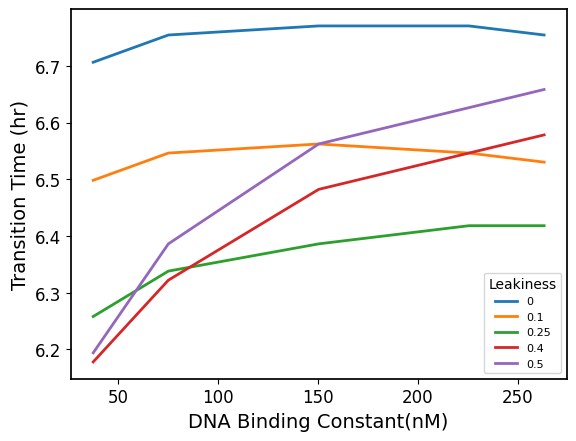

In [21]:
plot_2param_vary(metrics_dna_df, 'Kd2', 'transition_time', 'DNA Binding Constant(nM)', 'Transition Time (hr)')

## compiled dynamics image for leakiness + dCas9 repression strength

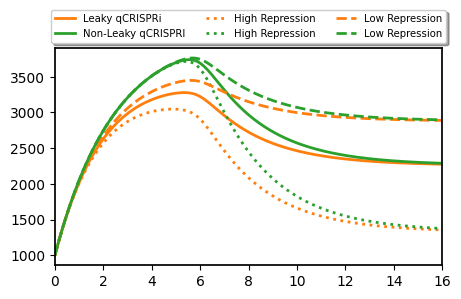

In [6]:
cmap = plt.get_cmap("tab10")
colors = cmap.colors
fig, ax = plt.subplots(figsize=(5,2.82))
plt.plot(t, gfp_dcas9_df[(gfp_dcas9_df["alphaT"] == alpha0) & (gfp_dcas9_df['activity_ratio'] == 0.4)].GFP, linewidth = 2, label='Leaky qCRISPRi', color = colors[1])
plt.plot(t, gfp_dcas9_df[(gfp_dcas9_df["alphaT"] == 0) & (gfp_dcas9_df['activity_ratio'] == 0.4)].GFP, linewidth = 2, label='Non-Leaky qCRISPRI', color = colors[2])
plt.plot(t, gfp_dcas9_df[(gfp_dcas9_df["alphaT"] == alpha0) & (gfp_dcas9_df['activity_ratio'] == 0.1)].GFP, linewidth = 2, label='High Repression', linestyle = ':', color = colors[1])
plt.plot(t, gfp_dcas9_df[(gfp_dcas9_df["alphaT"] == 0) & (gfp_dcas9_df['activity_ratio'] == 0.1)].GFP, linewidth = 2, label='High Repression', linestyle = ':',  color = colors[2])
plt.plot(t, gfp_dcas9_df[(gfp_dcas9_df["alphaT"] == alpha0) & (gfp_dcas9_df['activity_ratio'] == 0.6)].GFP, linewidth = 2, label='Low Repression', linestyle = '--',  color = colors[1]) 
plt.plot(t, gfp_dcas9_df[(gfp_dcas9_df["alphaT"] == 0) & (gfp_dcas9_df['activity_ratio'] == 0.6)].GFP, linewidth = 2, label='Low Repression', linestyle = '--', color = colors[2])
ax.set_xlim(0,16)
for i in ['right', 'left', 'top', 'bottom']:
    ax.spines[i].set(linewidth = 1.25)
#ax.set_xlabel('Time (hr)', fontsize = 16)
#ax.set_ylabel('gfp_dcas9_df Fluorescence [au]',  fontsize = 16)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
          ncol=3, fancybox=True, shadow=True,prop={'size': 7.25})

plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.rc('legend', fontsize=8)
#plt.savefig('Figures\leaky_reprstrength_dynamics.png', dpi = 386, bbox_inches = "tight")

## compiled dynamics image for leakiness + Kcomplex LuxR:AHL

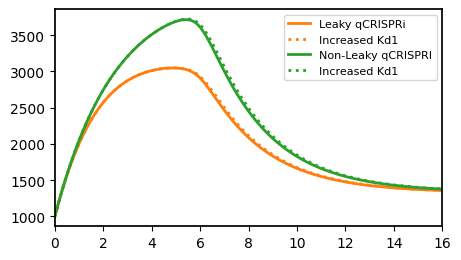

In [7]:
cmap = plt.get_cmap("tab10")
colors = cmap.colors
fig, ax = plt.subplots(figsize=(5, 2.82))
plt.plot(t, gfp_complex_df[(gfp_complex_df["alphaT"] == alpha0) & (gfp_complex_df['Kd1'] == kd1)].GFP, linewidth = 2, label='Leaky qCRISPRi', color = colors[1]) 
plt.plot(t, gfp_complex_df[(gfp_complex_df["alphaT"] == alpha0) & (gfp_complex_df['Kd1'] == kd1*1.75)].GFP, linewidth = 2, label='Increased Kd1', linestyle = ':', color = colors[1]) 
plt.plot(t, gfp_complex_df[(gfp_complex_df["alphaT"] == 0) & (gfp_complex_df['Kd1'] == kd1)].GFP, linewidth = 2, label='Non-Leaky qCRISPRI', color = colors[2])
plt.plot(t, gfp_complex_df[(gfp_complex_df["alphaT"] == 0) & (gfp_complex_df['Kd1'] == kd1*1.75)].GFP, linewidth = 2, label='Increased Kd1', linestyle = ':',  color = colors[2])
ax.set_xlim(0,16)
for i in ['right', 'left', 'top', 'bottom']:
    ax.spines[i].set(linewidth = 1.25)
#ax.set_xlabel('Time (hr)', fontsize = 16)
#ax.set_ylabel('GFP Fluorescence [au]',  fontsize = 16)
ax.legend(loc = 'upper right')
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.rc('legend', fontsize=7)
#plt.savefig('Figures\leaky_kd1_dynamics.png', dpi = 386, bbox_inches = "tight")

## compiled dynamics image for leakiness + Kdna_bind of LuxR:AHL complex

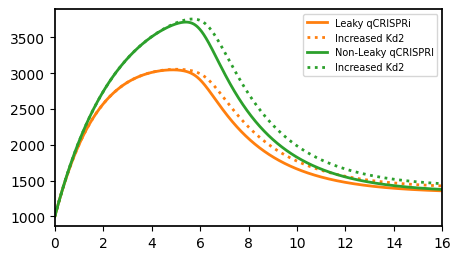

In [9]:
cmap = plt.get_cmap("tab10")
colors = cmap.colors
fig, ax = plt.subplots(figsize=(5,2.82))
plt.plot(t, gfp_dna_df[(gfp_dna_df["alphaT"] == alpha0) & (gfp_dna_df['Kd2'] == kd2)].GFP, linewidth = 2, label='Leaky qCRISPRi', color = colors[1]) 
plt.plot(t, gfp_dna_df[(gfp_dna_df["alphaT"] == alpha0) & (gfp_dna_df['Kd2'] == kd2*1.75)].GFP, linewidth = 2, label='Increased Kd2', linestyle = ':', color = colors[1]) 
plt.plot(t, gfp_dna_df[(gfp_dna_df["alphaT"] == 0) & (gfp_dna_df['Kd2'] == kd2)].GFP, linewidth = 2, label='Non-Leaky qCRISPRI', color = colors[2])
plt.plot(t, gfp_dna_df[(gfp_dna_df["alphaT"] == 0) & (gfp_dna_df['Kd2'] == kd2*1.75)].GFP, linewidth = 2, label='Increased Kd2', linestyle = ':',  color = colors[2])
ax.set_xlim(0,16)
for i in ['right', 'left', 'top', 'bottom']:
    ax.spines[i].set(linewidth = 1.25)
#ax.set_xlabel('Time (hr)', fontsize = 16)
#ax.set_ylabel('GFP Fluorescence [au]',  fontsize = 16)
ax.legend(loc = 'upper right')
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.rc('legend', fontsize=7)
#plt.savefig('Figures\leaky_kdna_dynamics.png', dpi = 386, bbox_inches = "tight")

## compiled image for dynamics parameters

In [31]:
leaky_dcas9_rows =  (metrics_dcas9_df.alphaT == alpha0) | (metrics_dcas9_df.alphaT == 0) 
leaky_kd1_rows =  (metrics_complex_df.alphaT == alpha0) | (metrics_complex_df.alphaT == 0) 
leaky_kd2_rows =  (metrics_dna_df.alphaT == alpha0) | (metrics_dna_df.alphaT == 0) 
activity_ratio_rows = (metrics_dcas9_df.activity_ratio == 0.6) | (metrics_dcas9_df.activity_ratio == 0.4) | (metrics_dcas9_df.activity_ratio == 0.1)
kd1_rows = (metrics_complex_df.Kd1 == kd1*0.25) | (metrics_complex_df.Kd1 == kd1) | (metrics_complex_df.Kd1 == kd1*1.75)
kd2_rows = (metrics_dna_df.Kd2 == kd2*0.25) | (metrics_dna_df.Kd2 == kd2) | (metrics_dna_df.Kd2 == kd2*1.75)

leaky_activity_rows = leaky_dcas9_rows & activity_ratio_rows
leaky_kd1_rows = leaky_kd1_rows & kd1_rows
leaky_kd2_rows = leaky_kd2_rows & kd2_rows

metrics_repr_strnth = metrics_dcas9_df[leaky_activity_rows]
metrics_leaky_kd1 = metrics_complex_df[leaky_kd1_rows]
metrics_leaky_kd2 = metrics_dna_df[leaky_kd2_rows]


/var/folders/bf/wlmhvvbx0n768cmc2p56f27m0000gn/T/ipykernel_46365/253365612.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(labels = ['','40', '70', '90'])
/var/folders/bf/wlmhvvbx0n768cmc2p56f27m0000gn/T/ipykernel_46365/253365612.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(labels = ['','40', '70', '90'])
/var/folders/bf/wlmhvvbx0n768cmc2p56f27m0000gn/T/ipykernel_46365/253365612.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(labels = ['','40', '70', '90'])
/var/folders/bf/wlmhvvbx0n768cmc2p56f27m0000gn/T/ipykernel_46365/253365612.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator

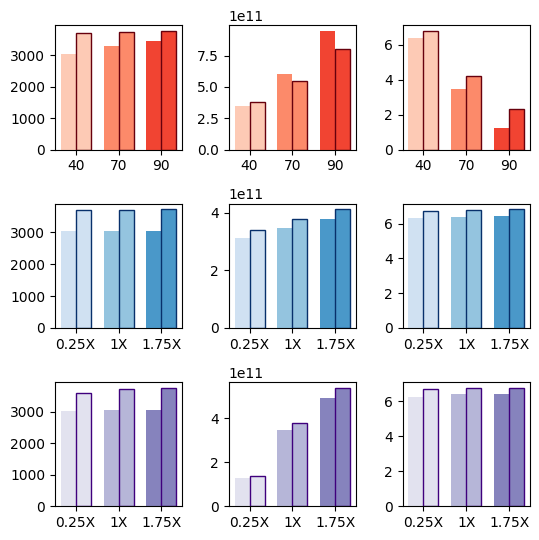

In [29]:
cmap1 = plt.get_cmap('Reds')
colors1 = cmap1([0.2, 0.4, 0.6, 1])
cmap2 = plt.get_cmap('Blues')
colors2 = cmap2([0.2, 0.4, 0.6, 1])
cmap3 = plt.get_cmap('Purples')
colors3 = cmap3([0.2, 0.4, 0.6, 1])


x = np.arange(3)  # the label locations
width = 0.35  # the width of the bars

#to create clusters of leaky and non-leaky data had to divided based on second parameter. 
bar1 = metrics_repr_strnth[metrics_repr_strnth['alphaT'] == alpha0].max_gfp
bar2 = metrics_repr_strnth[metrics_repr_strnth['alphaT'] == 0].max_gfp
bar3 = metrics_repr_strnth[metrics_repr_strnth['alphaT'] == alpha0].switching_density
bar4 = metrics_repr_strnth[metrics_repr_strnth['alphaT'] == 0].switching_density
bar5 = metrics_repr_strnth[metrics_repr_strnth['alphaT'] == alpha0].transition_time
bar6 = metrics_repr_strnth[metrics_repr_strnth['alphaT'] == 0].transition_time
bar7 = metrics_leaky_kd1[metrics_leaky_kd1['alphaT'] == alpha0].max_gfp
bar8 = metrics_leaky_kd1[metrics_leaky_kd1['alphaT'] == 0].max_gfp
bar9 = metrics_leaky_kd1[metrics_leaky_kd1['alphaT'] == alpha0].switching_density
bar10 = metrics_leaky_kd1[metrics_leaky_kd1['alphaT'] == 0].switching_density
bar11 = metrics_leaky_kd1[metrics_leaky_kd1['alphaT'] == alpha0].transition_time
bar12 = metrics_leaky_kd1[metrics_leaky_kd1['alphaT'] == 0].transition_time
bar13 = metrics_leaky_kd2[metrics_leaky_kd2['alphaT'] == alpha0].max_gfp
bar14 = metrics_leaky_kd2[metrics_leaky_kd2['alphaT'] == 0].max_gfp
bar15 = metrics_leaky_kd2[metrics_leaky_kd2['alphaT'] == alpha0].switching_density
bar16 = metrics_leaky_kd2[metrics_leaky_kd2['alphaT'] == 0].switching_density
bar17 = metrics_leaky_kd2[metrics_leaky_kd2['alphaT'] == alpha0].transition_time
bar18 = metrics_leaky_kd2[metrics_leaky_kd2['alphaT'] == 0].transition_time


fig, ((ax1, ax2, ax3),(ax4, ax5, ax6),(ax7, ax8, ax9)) = plt.subplots(3, 3, figsize = (5.5,5.5))
ax1.bar(x - width/2, bar1, width, color = [colors1[0], colors1[1], colors1[2]])
ax1.bar(x + width/2, bar2, width, color = [colors1[0], colors1[1], colors1[2]], edgecolor = colors1[3])
ax2.bar(x - width/2, bar3, width, color = [colors1[0], colors1[1], colors1[2]])
ax2.bar(x + width/2, bar4, width, color = [colors1[0], colors1[1], colors1[2]], edgecolor = colors1[3])
ax3.bar(x - width/2, bar5, width, color = [colors1[0], colors1[1], colors1[2]])
ax3.bar(x + width/2, bar6, width, color = [colors1[0], colors1[1], colors1[2]], edgecolor = colors1[3])
ax4.bar(x - width/2, bar7, width, color = [colors2[0], colors2[1], colors2[2]])
ax4.bar(x + width/2, bar8, width, color = [colors2[0], colors2[1], colors2[2]], edgecolor = colors2[3])
ax5.bar(x - width/2, bar9, width, color = [colors2[0], colors2[1], colors2[2]])
ax5.bar(x + width/2, bar10, width, color = [colors2[0], colors2[1], colors2[2]], edgecolor = colors2[3])
ax6.bar(x - width/2, bar11, width, color = [colors2[0], colors2[1], colors2[2]])
ax6.bar(x + width/2, bar12, width, color = [colors2[0], colors2[1], colors2[2]], edgecolor = colors2[3])
ax7.bar(x - width/2, bar13, width, color = [colors3[0], colors3[1], colors3[2]])
ax7.bar(x + width/2, bar14, width, color = [colors3[0], colors3[1], colors3[2]], edgecolor = colors3[3])
ax8.bar(x - width/2, bar15, width, color = [colors3[0], colors3[1], colors3[2]])
ax8.bar(x + width/2, bar16, width, color = [colors3[0], colors3[1], colors3[2]], edgecolor = colors3[3])
ax9.bar(x - width/2, bar17, width, color = [colors3[0], colors3[1], colors3[2]])
ax9.bar(x + width/2, bar18, width, color = [colors3[0], colors3[1], colors3[2]], edgecolor = colors3[3])






#ax1.set_ylabel('Max GFP')
#ax2.set_ylabel('Switching Density\n(CFU/mL)')
#ax3.set_ylabel('Transition Time (hr)')
#ax4.set_ylabel('Max GFP')
#ax5.set_ylabel('Switching Density\n(CFU/mL)')
#ax6.set_ylabel('Transition Time (hr)')
#ax7.set_ylabel('Max GFP')
#ax8.set_ylabel('Switching Density\n(CFU/mL)')
#ax9.set_ylabel('Transition Time (hr)')


#for some reason first label goes missing. 
ax1.set_xticklabels(labels = ['','40', '70', '90'])
ax2.set_xticklabels(labels = ['','40', '70', '90'])
ax3.set_xticklabels(labels = ['','40', '70', '90'])
ax4.set_xticklabels(labels = ['','0.25X', '1X', '1.75X'])
ax5.set_xticklabels(labels = ['','0.25X', '1X', '1.75X'])
ax6.set_xticklabels(labels = ['','0.25X', '1X', '1.75X'])
ax7.set_xticklabels(labels = ['','0.25X', '1X', '1.75X'])
ax8.set_xticklabels(labels = ['','0.25X', '1X', '1.75X'])
ax9.set_xticklabels(labels = ['','0.25X', '1X', '1.75X'])

fig.tight_layout()
#plt.savefig('Figures/twosensi_param_compile.png', dpi = 350, bbox_inches = "tight")

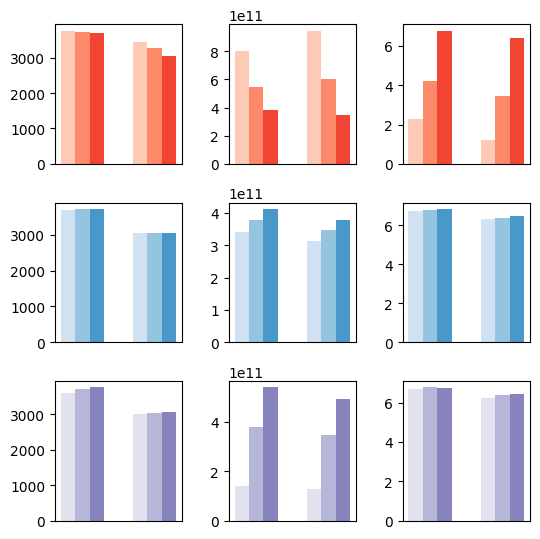

In [30]:
cmap1 = plt.get_cmap('Reds')
colors1 = cmap1([0.2, 0.4, 0.6])
cmap2 = plt.get_cmap('Blues')
colors2 = cmap2([0.2, 0.4, 0.6])
cmap3 = plt.get_cmap('Purples')
colors3 = cmap3([0.2, 0.4, 0.6])


x = np.arange(2)  # the label locations
width = 0.20  # the width of the bars

#to create clusters of leaky and non-leaky data had to divided based on second parameter. 
bar1 = metrics_repr_strnth[metrics_repr_strnth['activity_ratio'] == 0.6].max_gfp
bar2 = metrics_repr_strnth[metrics_repr_strnth['activity_ratio'] == 0.4].max_gfp
bar3 = metrics_repr_strnth[metrics_repr_strnth['activity_ratio'] == 0.1].max_gfp
bar4 = metrics_repr_strnth[metrics_repr_strnth['activity_ratio'] == 0.6].switching_density
bar5 = metrics_repr_strnth[metrics_repr_strnth['activity_ratio'] == 0.4].switching_density
bar6 = metrics_repr_strnth[metrics_repr_strnth['activity_ratio'] == 0.1].switching_density
bar7 = metrics_repr_strnth[metrics_repr_strnth['activity_ratio'] == 0.6].transition_time
bar8 = metrics_repr_strnth[metrics_repr_strnth['activity_ratio'] == 0.4].transition_time
bar9 = metrics_repr_strnth[metrics_repr_strnth['activity_ratio'] == 0.1].transition_time
bar10 = metrics_leaky_kd1[metrics_leaky_kd1['Kd1'] == kd1*0.25].max_gfp
bar11 = metrics_leaky_kd1[metrics_leaky_kd1['Kd1'] == kd1].max_gfp
bar12 = metrics_leaky_kd1[metrics_leaky_kd1['Kd1'] == kd1*1.75].max_gfp
bar13 = metrics_leaky_kd1[metrics_leaky_kd1['Kd1'] == kd1*0.25].switching_density
bar14 = metrics_leaky_kd1[metrics_leaky_kd1['Kd1'] == kd1].switching_density
bar15 = metrics_leaky_kd1[metrics_leaky_kd1['Kd1'] == kd1*1.75].switching_density
bar16 = metrics_leaky_kd1[metrics_leaky_kd1['Kd1'] == kd1*0.25].transition_time
bar17 = metrics_leaky_kd1[metrics_leaky_kd1['Kd1'] == kd1].transition_time
bar18 = metrics_leaky_kd1[metrics_leaky_kd1['Kd1'] == kd1*1.75].transition_time
bar19 = metrics_leaky_kd2[metrics_leaky_kd2['Kd2'] == kd2*0.25].max_gfp
bar20 = metrics_leaky_kd2[metrics_leaky_kd2['Kd2'] == kd2].max_gfp
bar21 = metrics_leaky_kd2[metrics_leaky_kd2['Kd2'] == kd2*1.75].max_gfp
bar22 = metrics_leaky_kd2[metrics_leaky_kd2['Kd2'] == kd2*0.25].switching_density
bar23 = metrics_leaky_kd2[metrics_leaky_kd2['Kd2'] == kd2].switching_density
bar24 = metrics_leaky_kd2[metrics_leaky_kd2['Kd2'] == kd2*1.75].switching_density
bar25 = metrics_leaky_kd2[metrics_leaky_kd2['Kd2'] == kd2*0.25].transition_time
bar26 = metrics_leaky_kd2[metrics_leaky_kd2['Kd2'] == kd2].transition_time
bar27 = metrics_leaky_kd2[metrics_leaky_kd2['Kd2'] == kd2*1.75].transition_time


fig, ((ax1, ax2, ax3),(ax4, ax5, ax6),(ax7, ax8, ax9)) = plt.subplots(3, 3, figsize = (5.5,5.5))
ax1.bar(x - width, bar1, width, color = colors1[0] )
ax1.bar(x,         bar2, width, color = colors1[1] )
ax1.bar(x + width, bar3, width, color = colors1[2] )
ax2.bar(x - width, bar4, width, color = colors1[0] )
ax2.bar(x,         bar5, width, color = colors1[1] )
ax2.bar(x + width, bar6, width, color = colors1[2] )
ax3.bar(x - width, bar7, width, color = colors1[0] )
ax3.bar(x,         bar8, width, color = colors1[1] )
ax3.bar(x + width, bar9, width, color = colors1[2] )
ax4.bar(x - width, bar10, width, color = colors2[0] )
ax4.bar(x,         bar11, width, color = colors2[1] )
ax4.bar(x + width, bar12, width, color = colors2[2] )
ax5.bar(x - width, bar13, width, color = colors2[0] )
ax5.bar(x,         bar14, width, color = colors2[1] )
ax5.bar(x + width, bar15, width, color = colors2[2] )
ax6.bar(x - width, bar16, width, color = colors2[0] )
ax6.bar(x,         bar17, width, color = colors2[1] )
ax6.bar(x + width, bar18, width, color = colors2[2] )
ax7.bar(x - width, bar19, width, color = colors3[0] )
ax7.bar(x,         bar20, width, color = colors3[1] )
ax7.bar(x + width, bar21, width, color = colors3[2] )
ax8.bar(x - width, bar22, width, color = colors3[0] )
ax8.bar(x,         bar23, width, color = colors3[1] )
ax8.bar(x + width, bar24, width, color = colors3[2] )
ax9.bar(x - width, bar25, width, color = colors3[0] )
ax9.bar(x,         bar26, width, color = colors3[1] )
ax9.bar(x + width, bar27, width, color = colors3[2] )



#ax1.set_ylabel('Max GFP')
#ax2.set_ylabel('Switching Density\n(CFU/mL)')
#ax3.set_ylabel('Transition Time (hr)')
#ax4.set_ylabel('Max GFP')
#ax5.set_ylabel('Switching Density\n(CFU/mL)')
#ax6.set_ylabel('Transition Time (hr)')
#ax7.set_ylabel('Max GFP')
#ax8.set_ylabel('Switching Density\n(CFU/mL)')
#ax9.set_ylabel('Transition Time (hr)')


#for some reason first label goes missing. 
ax1.set_xticklabels(labels = '')
ax2.set_xticklabels(labels = '')
ax3.set_xticklabels(labels = '')
ax4.set_xticklabels(labels = '')
ax5.set_xticklabels(labels = '')
ax6.set_xticklabels(labels = '')
ax7.set_xticklabels(labels = '')
ax8.set_xticklabels(labels = '')
ax9.set_xticklabels(labels = '')


ax1.tick_params(bottom = False)
ax2.tick_params(bottom = False)
ax3.tick_params(bottom = False)
ax4.tick_params(bottom = False)
ax5.tick_params(bottom = False)
ax6.tick_params(bottom = False)
ax7.tick_params(bottom = False)
ax8.tick_params(bottom = False)
ax9.tick_params(bottom = False)


fig.tight_layout()
#plt.savefig('Figures\leaky_nonleaky_twosensi_param_compile.png', dpi = 350, bbox_inches = "tight")

## heat map for % change in parameter

In [6]:
leaky_dcas9_rows =  (metrics_dcas9_df.alphaT == alpha0) | (metrics_dcas9_df.alphaT == 0) 
leaky_kd1_rows =  (metrics_complex_df.alphaT == alpha0) | (metrics_complex_df.alphaT == 0) 
leaky_kd2_rows =  (metrics_dna_df.alphaT == alpha0) | (metrics_dna_df.alphaT == 0) 

repr_paramData1 = metrics_dcas9_df[leaky_dcas9_rows]
kd1_paramData1 = metrics_complex_df[leaky_kd1_rows]
kd2_paramData1 = metrics_dna_df[leaky_kd2_rows]

leakydf = repr_paramData1[repr_paramData1['alphaT'] == alpha0]
nonleakydf = repr_paramData1[repr_paramData1['alphaT'] == 0]



In [7]:
def calculate_percent_change(metrics_df:pd.DataFrame, param_name:str, param_value:float, base_param_value: float, metric_name:str):

    #calculate percent change
    new_param_metrics = metrics_df[metrics_df[param_name] == param_value]
    base_param_metrics = metrics_df[metrics_df[param_name] == base_param_value]

    percent_change_metric = 100*(new_param_metrics[metric_name].values[0] - base_param_metrics[metric_name].values[0])/base_param_metrics[metric_name].values[0]
    return percent_change_metric


In [11]:
def calculate_percent_change_metrics(metrics_df:pd.DataFrame, parameter_name:str, parameter_value:float, base_parameter_value:float):
    change_in_max_gfp = calculate_percent_change(metrics_df, param_name = parameter_name, param_value = parameter_value, base_param_value= base_parameter_value, metric_name= 'max_gfp')
    change_in_switching_density = calculate_percent_change(metrics_df, param_name = parameter_name, param_value = parameter_value, base_param_value= base_parameter_value, metric_name= 'switching_density')
    change_in_fold_repression = calculate_percent_change(metrics_df, param_name = parameter_name, param_value = parameter_value, base_param_value= base_parameter_value, metric_name= 'fold_repression')
    change_in_transition_time = calculate_percent_change(metrics_df, param_name = parameter_name, param_value = parameter_value, base_param_value= base_parameter_value, metric_name= 'transition_time')
    return [change_in_max_gfp, change_in_switching_density, change_in_fold_repression, change_in_transition_time]


In [24]:
#calculaitng percent change in metrics when activity_ratio or repression strength of dCas9 is varied. activity ration of 0.6 or repression strength of 40% is used a base value

activity_ratio_percent_change = pd.DataFrame(columns = ['max_gfp_leaky', 'max_gfp_nonleaky', 'fold_repression_leaky','fold_repression_nonleaky', 
                                                        'transition_time_leaky', 'transition_time_nonleaky', 'switching_density_leaky', 'switching_density_nonleaky'])
for i in [0.1, 0.2, 0.3, 0.4, 0.5]:
    percent_change_leaky_metrics   = calculate_percent_change_metrics(leakydf, parameter_name = 'activity_ratio', parameter_value= i, base_parameter_value=0.6)
    percent_change_nonleaky_metrics   = calculate_percent_change_metrics(nonleakydf, parameter_name = 'activity_ratio', parameter_value= i, base_parameter_value=0.6)
    newrow = {'max_gfp_leaky': percent_change_leaky_metrics[0], 
              'max_gfp_nonleaky': percent_change_nonleaky_metrics[0],
              'switching_density_leaky':percent_change_leaky_metrics[1], 
              'switching_density_nonleaky':percent_change_nonleaky_metrics[1], 
              'fold_repression_leaky':percent_change_leaky_metrics[2], 
              'fold_repression_nonleaky':percent_change_nonleaky_metrics[2], 
              'transition_time_leaky':percent_change_leaky_metrics[3],
              'transition_time_nonleaky':percent_change_nonleaky_metrics[3] }
                
    activity_ratio_percent_change = pd.concat([activity_ratio_percent_change, pd.DataFrame([newrow])], ignore_index = True)
activity_ratio_percent_change

/var/folders/bf/wlmhvvbx0n768cmc2p56f27m0000gn/T/ipykernel_49008/2790347251.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  activity_ratio_percent_change = pd.concat([activity_ratio_percent_change, pd.DataFrame([newrow])], ignore_index = True)


,max_gfp_leaky,max_gfp_nonleaky,fold_repression_leaky,fold_repression_nonleaky,transition_time_leaky,transition_time_nonleaky,switching_density_leaky,switching_density_nonleaky
0,-11.657595,-1.274439,91.422131,91.422131,425.000000,425.000000,-63.228671,-63.228671
1,-9.522356,-1.073917,58.954532,58.954532,342.105263,342.105263,-57.158580,-57.158580
2,-7.290430,-0.853249,36.961297,36.961297,263.157895,263.157895,-48.648240,-48.648240
3,-4.963200,-0.607473,21.127357,21.127357,182.894737,182.894737,-35.873022,-35.873022
4,-2.537186,-0.327898,9.226370,9.226370,98.684211,98.684211,-18.835806,-18.835806


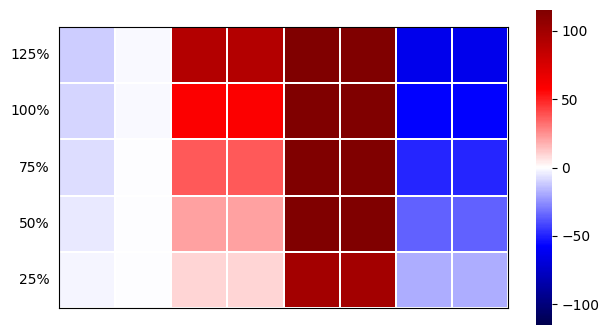

In [26]:
ax = sns.heatmap(activity_ratio_percent_change, linewidth=.05, cmap='seismic', square = True, 
                 cbar_kws={ 'shrink':0.7}, vmin =-115, vmax = 115 )
ax.set_ylim(5, 0)
ax.tick_params(bottom = False, left = False)
ax.set_xticklabels(labels = '')
ax.set_yticklabels(labels = ['125%', '100%', '75%', '50%', '25%'], rotation = 360)
for _, spine in ax.spines.items():
    spine.set_visible(True)
plt.tight_layout()
#plt.savefig('Figures/activity_ratio_heatmap.png', dpi = 350, bbox_inches = 'tight')

In [13]:
#calculaitng percent change in metrics when Kd1 is varied. 

kd1_leakydf = kd1_paramData1[kd1_paramData1['alphaT'] == alpha0]
kd1_nonleakydf = kd1_paramData1[kd1_paramData1['alphaT'] == 0]

kd1_percent_change = pd.DataFrame(columns = ['max_gfp_leaky', 'max_gfp_nonleaky', 'fold_repression_leaky','fold_repression_nonleaky', 
                                                        'transition_time_leaky', 'transition_time_nonleaky', 'switching_density_leaky', 'switching_density_nonleaky'])
for i in Kd1_range:
    percent_change_leaky_metrics   = calculate_percent_change_metrics(kd1_leakydf, parameter_name = 'Kd1', parameter_value= i, base_parameter_value=get_default_param_value('Kd1'))
    percent_change_nonleaky_metrics   = calculate_percent_change_metrics(kd1_nonleakydf, parameter_name = 'Kd1', parameter_value= i, base_parameter_value= get_default_param_value('Kd1'))
    newrow = {'max_gfp_leaky': percent_change_leaky_metrics[0], 
              'max_gfp_nonleaky': percent_change_nonleaky_metrics[0],
              'switching_density_leaky':percent_change_leaky_metrics[1], 
              'switching_density_nonleaky':percent_change_nonleaky_metrics[1], 
              'fold_repression_leaky':percent_change_leaky_metrics[2], 
              'fold_repression_nonleaky':percent_change_nonleaky_metrics[2], 
              'transition_time_leaky':percent_change_leaky_metrics[3],
              'transition_time_nonleaky':percent_change_nonleaky_metrics[3] }
                
    kd1_percent_change = pd.concat([kd1_percent_change, pd.DataFrame([newrow])], ignore_index = True)
kd1_percent_change

/var/folders/bf/wlmhvvbx0n768cmc2p56f27m0000gn/T/ipykernel_53032/357851768.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kd1_percent_change = pd.concat([kd1_percent_change, pd.DataFrame([newrow])], ignore_index = True)


,max_gfp_leaky,max_gfp_nonleaky,fold_repression_leaky,fold_repression_nonleaky,transition_time_leaky,transition_time_nonleaky,switching_density_leaky,switching_density_nonleaky
0,-0.064618,-0.263900,-0.023226,-0.219056,-1.002506,-0.709220,-10.368668,-9.918245
1,-0.041816,-0.171576,-0.014200,-0.141637,-0.501253,-0.236407,-6.977141,-6.663093
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.037311,0.156348,0.009621,0.126248,0.751880,0.709220,5.388771,5.115606
4,0.054569,0.229539,0.013008,0.184332,1.002506,0.709220,9.048172,8.574405


In [14]:
#calculaitng percent change in metrics when Kd2 is varied. 

kd2_leakydf = kd2_paramData1[kd2_paramData1['alphaT'] == alpha0]
kd2_nonleakydf = kd2_paramData1[kd2_paramData1['alphaT'] == 0]

kd2_percent_change = pd.DataFrame(columns = ['max_gfp_leaky', 'max_gfp_nonleaky', 'fold_repression_leaky','fold_repression_nonleaky', 
                                                        'transition_time_leaky', 'transition_time_nonleaky', 'switching_density_leaky', 'switching_density_nonleaky'])
for i in Kd2_range:
    percent_change_leaky_metrics   = calculate_percent_change_metrics(kd2_leakydf, parameter_name = 'Kd2', parameter_value= i, base_parameter_value=get_default_param_value('Kd2'))
    percent_change_nonleaky_metrics   = calculate_percent_change_metrics(kd2_nonleakydf, parameter_name = 'Kd2', parameter_value= i, base_parameter_value= get_default_param_value('Kd2'))
    newrow = {'max_gfp_leaky': percent_change_leaky_metrics[0], 
              'max_gfp_nonleaky': percent_change_nonleaky_metrics[0],
              'switching_density_leaky':percent_change_leaky_metrics[1], 
              'switching_density_nonleaky':percent_change_nonleaky_metrics[1], 
              'fold_repression_leaky':percent_change_leaky_metrics[2], 
              'fold_repression_nonleaky':percent_change_nonleaky_metrics[2], 
              'transition_time_leaky':percent_change_leaky_metrics[3],
              'transition_time_nonleaky':percent_change_nonleaky_metrics[3] }
                
    kd2_percent_change = pd.concat([kd2_percent_change, pd.DataFrame([newrow])], ignore_index = True)
kd2_percent_change

/var/folders/bf/wlmhvvbx0n768cmc2p56f27m0000gn/T/ipykernel_53032/3665668116.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kd2_percent_change = pd.concat([kd2_percent_change, pd.DataFrame([newrow])], ignore_index = True)


,max_gfp_leaky,max_gfp_nonleaky,fold_repression_leaky,fold_repression_nonleaky,transition_time_leaky,transition_time_nonleaky,switching_density_leaky,switching_density_nonleaky
0,-1.024203,-3.220580,4.571324,2.631039,-2.005013,-9.456265e-01,-62.840589,-63.427495
1,-0.444628,-1.560239,3.183095,2.296536,-0.751880,-2.364066e-01,-38.859596,-38.977510
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
3,0.198619,0.847817,-3.024873,-2.705001,0.501253,1.311883e-14,29.911425,29.857441
4,0.263336,1.156806,-4.437392,-4.057365,0.501253,-2.364066e-01,41.607148,42.394153


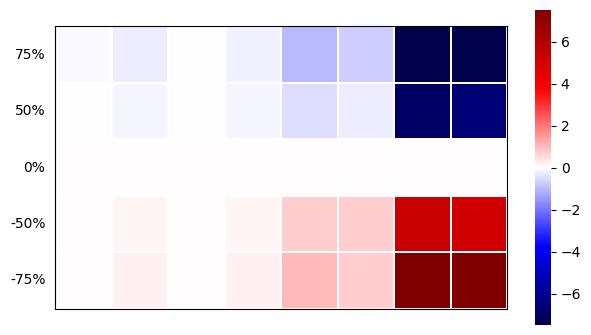

In [15]:
ax = sns.heatmap(kd1_percent_change, linewidth=.05, cmap='seismic', square = True, 
                 cbar_kws={ 'shrink':0.7}, vmin =-7.5, vmax = 7.5 )
ax.set_ylim(5, 0)
ax.tick_params(bottom = False, left = False)
ax.set_xticklabels(labels = '')
ax.set_yticklabels(labels = ['75%', '50%', '0%', '-50%', '-75%'], rotation = 360)
for _, spine in ax.spines.items():
    spine.set_visible(True)
plt.tight_layout()
#plt.savefig('Figures\kd1_heatmap.png', dpi = 350, bbox_inches = 'tight')

<>:10: SyntaxWarning: invalid escape sequence '\k'
<>:10: SyntaxWarning: invalid escape sequence '\k'
/var/folders/bf/wlmhvvbx0n768cmc2p56f27m0000gn/T/ipykernel_53032/3320939758.py:10: SyntaxWarning: invalid escape sequence '\k'
  plt.savefig('Figures\kd2_heatmap.png', dpi =350, bbox_inches = 'tight')


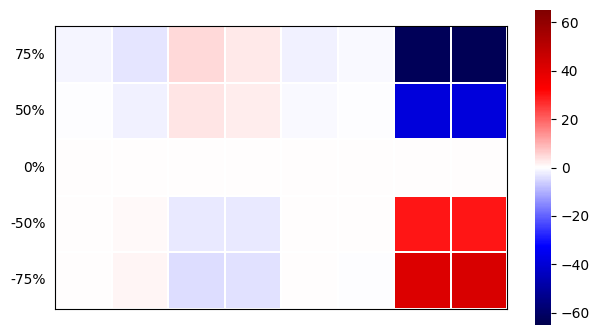

In [16]:
ax = sns.heatmap(kd2_percent_change, linewidth=.05, cmap='seismic', square = True, cbar_kws={ 'shrink':0.7},
                vmin = -65, vmax = 65)
ax.set_ylim(5, 0)
ax.tick_params(bottom = False, left = False)
ax.set_xticklabels(labels = '')
ax.set_yticklabels(labels = ['75%', '50%', '0%', '-50%', '-75%'], rotation = 360)
for _, spine in ax.spines.items():
    spine.set_visible(True)
plt.tight_layout()
plt.savefig('Figures\kd2_heatmap.png', dpi =350, bbox_inches = 'tight')

## compiled leaky vs non-leaky switch parameters

In [17]:
repr_paramData1

,alphaT,activity_ratio,switching_density,fold_repression,transition_time,max_gfp
0,0,0.1,3.791302e+11,2.783354,6.770257,3714.633053
1,0,0.2,4.182437e+11,2.264194,5.921974,3722.177849
2,0,0.3,4.719508e+11,1.909862,5.089697,3730.480655
3,0,0.4,5.466105e+11,1.652835,4.225408,3739.728218
4,0,0.5,6.507483e+11,1.458131,3.329110,3750.247438
5,0,0.6,8.039856e+11,1.305865,2.304768,3762.584887
12,0.25,0.1,3.476722e+11,2.293895,6.386129,3047.400472
13,0.25,0.2,4.050648e+11,1.904822,5.377793,3121.056258
14,0.25,0.3,4.855298e+11,1.641267,4.417472,3198.047283
15,0.25,0.4,6.063193e+11,1.451522,3.441147,3278.325842


In [18]:
leaky_repr = repr_paramData1[(repr_paramData1['alphaT'] == 0.25) & (repr_paramData1['activity_ratio'] == 0.1)]
nonleaky_repr = repr_paramData1[(repr_paramData1['alphaT'] == 0) & (repr_paramData1['activity_ratio'] == 0.1)]
gfp = 100*(nonleaky_repr.max_gfp.values[0]-leaky_repr.max_gfp.values[0])/nonleaky_repr.max_gfp.values[0]
density = 100*(nonleaky_repr.switching_density.values[0]-leaky_repr.switching_density.values[0])/nonleaky_repr.switching_density.values[0]
fold = 100*(nonleaky_repr.fold_repression.values[0]-leaky_repr.fold_repression.values[0])/nonleaky_repr.fold_repression.values[0]
time = 100*(nonleaky_repr.transition_time.values[0]-leaky_repr.transition_time.values[0])/nonleaky_repr.transition_time.values[0]

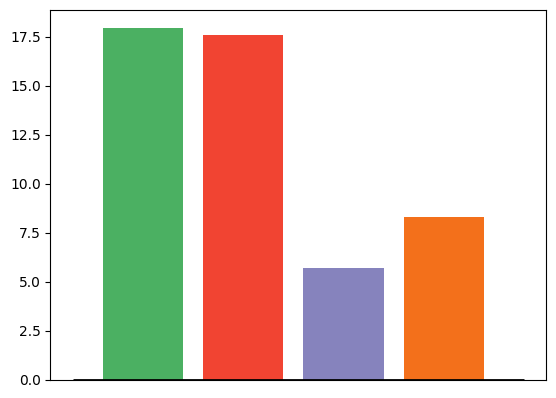

In [19]:
cmap1 = plt.get_cmap('Oranges')
orange = cmap1(0.6)
cmap2 = plt.get_cmap('Purples')
purple = cmap2(0.6)
cmap3 = plt.get_cmap('Greens')
green = cmap3(0.6)
cmap4 = plt.get_cmap('Reds')
red = cmap4(0.6)
X = np.arange(4)
width = 0.8
fig, ax = plt.subplots()
ax.bar(X-width, [gfp, fold, time, density], width, color = [green,  red, purple, orange,])
ax.tick_params(bottom = False)
ax.set_xticklabels(labels = '')
plt.hlines(y= 0, xmin= -1.5, xmax= 3, color='black', linewidth = 2)
plt.show()
#fig.savefig('Figures\params_leaky_vs_nonleaky.png', dpi = 350, bbox_inches = 'tight')

# Stringency of LuxR

## Variation in dynamics with change in stringency

In [26]:
less_stringent_sys = solve_qcrispri_simple()
high_stringent_sys = solve_qcrispri_simple(alphaRL = 0, KD =175)

wild_switch_density, wild_fold_repression, wild_transition_time = CalculateDynamicsMetrics(less_stringent_sys.GFP, t, less_stringent_sys.N).get_dynamic_metrics()
mutant_switch_density, mutant_fold_repression, mutant_transition_time = CalculateDynamicsMetrics(high_stringent_sys.GFP, t, high_stringent_sys.N).get_dynamic_metrics()

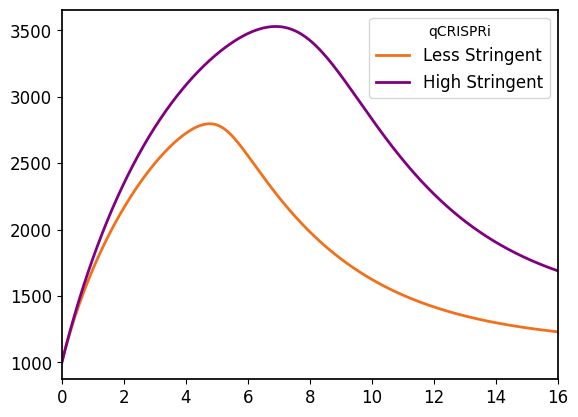

In [23]:


cmap1 = plt.get_cmap('Oranges')
color1 = cmap1(0.6)
fig, ax = plt.subplots()
plt.plot(t, less_stringent_sys.GFP, linewidth = 2, label='Less Stringent', color = color1) 
plt.plot(t, high_stringent_sys.GFP, linewidth = 2, label='High Stringent', color = 'purple') 



ax.set_xlim(0,16)
for i in ['right', 'left', 'top', 'bottom']:
    ax.spines[i].set(linewidth = 1.25)
#ax.set_xlabel('Time (hr)', fontsize = 16)
#ax.set_ylabel('GFP Fluorescence [au]',  fontsize = 16)
ax.legend(loc = 'upper right')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.rc('legend', fontsize=12)
plt.legend(title = 'qCRISPRi')
#plt.savefig('Figures\LuxR_str_dynamics.png',dpi = 600, bbox_inches = 'tight')

## bar plots for parameter variation.

In [27]:
str_df = pd.DataFrame(columns = ['wildtype', 'mutant'], index = ['max_gfp', 'switching_density', 'fold_repression', 'transition_time'])
row1 = {'wildtype': max(less_stringent_sys.GFP), 'mutant':max(high_stringent_sys.GFP)}
row2 = {'wildtype': wild_switch_density, 'mutant':mutant_switch_density}
row3 = {'wildtype': wild_fold_repression, 'mutant':mutant_fold_repression}
row4 = {'wildtype': wild_transition_time, 'mutant':mutant_transition_time}
str_df.loc['max_gfp'] = row1
str_df.loc['switching_density'] = row2
str_df.loc['fold_repression'] = row3
str_df.loc['transition_time'] = row4
str_df['percent_change'] = 100*(str_df.mutant - str_df.wildtype)/str_df.wildtype
str_df

,wildtype,mutant,percent_change
max_gfp,2796.019054,3528.089491,26.182598
switching_density,6104721340.946855,9787438543.268806,60.325722
fold_repression,2.454028,2.525283,2.903615
transition_time,8.978993,10.307436,14.795009


/var/folders/bf/wlmhvvbx0n768cmc2p56f27m0000gn/T/ipykernel_53032/440490260.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax1.bar(x        , [bar1[0]], width, color = color1)
/var/folders/bf/wlmhvvbx0n768cmc2p56f27m0000gn/T/ipykernel_53032/440490260.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax1.bar(x + width, [bar2[0]], width, color = color2)
/var/folders/bf/wlmhvvbx0n768cmc2p56f27m0000gn/T/ipykernel_53032/440490260.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior).

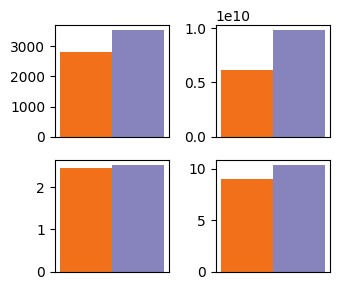

In [28]:
cmap1 = plt.get_cmap('Oranges')
color1 = cmap1(0.6)
cmap2 = plt.get_cmap('Purples')
color2 = cmap2(0.6)

x = np.arange(1)  # the label locations
width = 0.10  # the width of the bars
bar1 = str_df.wildtype
bar2 = str_df.mutant

fig, ((ax1,ax11),(ax2, ax21)) = plt.subplots(2,2, figsize=(3.5,3))
ax1.bar(x        , [bar1[0]], width, color = color1)
ax1.bar(x + width, [bar2[0]], width, color = color2)

#ax11 = ax1.twinx()
ax11.bar(1 - width, [bar1[1]], width, color = color1)
ax11.bar(1        , [bar2[1]], width, color = color2)
#ax1.set_ylabel('GFP (au)')
#ax11.set_ylabel('CFU/mL')

ax2.bar(x        , [bar1[2]], width, color = color1)
ax2.bar(x + width, [bar2[2]], width, color = color2)

#ax21 = ax2.twinx()
ax21.bar(1 - width, [bar1[3]], width, color = color1)
ax21.bar(1        , [bar2[3]], width, color = color2)
#ax2.set_ylabel('Fold Change')
#ax21.set_ylabel('Hours')

ax1.set_xticklabels(labels = '')
ax2.set_xticklabels(labels = '')
ax11.set_xticklabels(labels = '')
ax21.set_xticklabels(labels = '')
ax1.tick_params(bottom = False)
ax2.tick_params(bottom = False)
ax11.tick_params(bottom = False)
ax21.tick_params(bottom = False)
fig.tight_layout()
#fig.savefig('Figures\LuxR_str_param.png',dpi = 450,  bbox_inches = 'tight')

# Sponge design

In [2]:
decoy_range = [0, 2, 5, 10, 20, 40]
gfp_decoy, metrics_decoy = vary_decoysite("decoy_sites", decoy_range )

qcrispri_df = solve_qcrispri()

/Users/saiakhilgolla/Library/CloudStorage/OneDrive-Personal/Akhil/University/UofT- Masters/Quorum_Switch/src/sensitivity_analysis.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gfp_df = pd.concat([gfp_df, temp])


## compiled dynamics plot

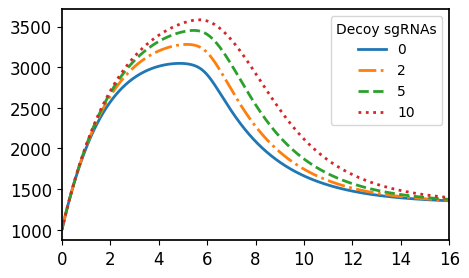

In [3]:
cmap = plt.get_cmap("tab10")
colors = cmap.colors
fig, ax = plt.subplots(figsize=(5, 3))
plt.plot(t, qcrispri_df.GFP, linewidth = 2, label='0', color = colors[0]) 
plt.plot(t, gfp_decoy[gfp_decoy["decoy_sites"] == 2].GFP, linewidth = 2, linestyle = "-.", label='2', color = colors[1])
plt.plot(t, gfp_decoy[gfp_decoy["decoy_sites"] == 5].GFP, linewidth = 2, linestyle = '--', label='5', color = colors[2])  
plt.plot(t, gfp_decoy[gfp_decoy["decoy_sites"] == 10].GFP, linewidth = 2, linestyle = ':', label='10', color = colors[3])
#plt.plot(t, gfp_decoy[gfp_decoy["decoy_sites"] == 20].GFP, linewidth = 2, linestyle = '-.', label='20', color = colors[4])
ax.set_xlim(0,16)
for i in ['right', 'left', 'top', 'bottom']:
    ax.spines[i].set(linewidth = 1.25)
#ax.set_xlabel('Time (hr)', fontsize = 16)
#ax.set_ylabel('GFP Fluorescence [au]',  fontsize = 16)
leg = ax.legend(prop={"size":12})
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(title = 'Decoy sgRNAs', loc='upper right')
plt.rc('legend', fontsize=12)
#plt.savefig('Figures\sponge_dynamics.png', dpi = 386, bbox_inches = 'tight')

## compiled parameter vary plot

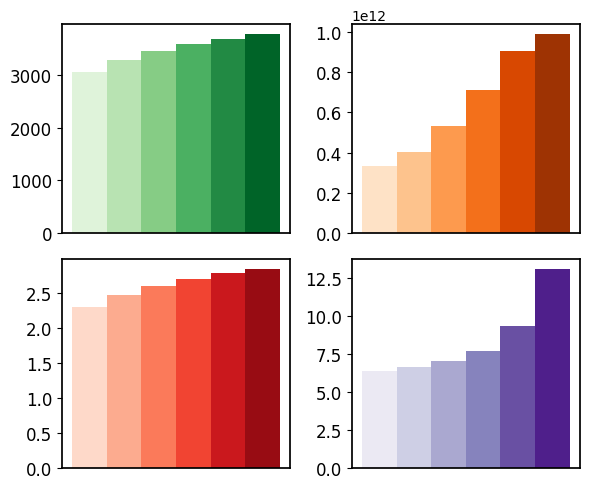

In [4]:
cmap1 = plt.get_cmap('Oranges')
colors1 = cmap1([0.15, 0.30, 0.45, 0.60, 0.75, 0.90])
cmap2 = plt.get_cmap('Purples')
colors2 = cmap2([0.15, 0.30, 0.45, 0.60, 0.75, 0.90])
cmap3 = plt.get_cmap('Greens')
colors3 = cmap3([0.15, 0.30, 0.45, 0.60, 0.75, 0.90])
cmap4 = plt.get_cmap('Reds')
colors4 = cmap4([0.15, 0.30, 0.45, 0.60, 0.75, 0.90])

width = 0.20
x = [(0-2*width), (0-width), 0, 0+width, 0+2*width, 0+3*width]
fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2,2, figsize = (6,5))
for i in range(len(x)):
    ax1.bar(x[i], metrics_decoy.max_gfp[i], width, color = colors3[i])
    ax2.bar(x[i], metrics_decoy.switching_density[i], width, color = colors1[i])
    ax3.bar(x[i], metrics_decoy.fold_repression[i], width, color = colors4[i])
    ax4.bar(x[i], metrics_decoy.transition_time[i], width, color = colors2[i])
for i in ['right', 'left', 'top', 'bottom']:
    ax1.spines[i].set(linewidth = 1.25)
    ax2.spines[i].set(linewidth = 1.25)
    ax3.spines[i].set(linewidth = 1.25)
    ax4.spines[i].set(linewidth = 1.25)

ax1.tick_params(labelsize = 12)
ax2.tick_params(labelsize = 12)
ax3.tick_params(labelsize = 12)
ax4.tick_params(labelsize = 12)
    
#ax1.set_ylabel('GFP (au)')
#ax2.set_ylabel('Cell Density (CFU/mL)')
#ax3.set_ylabel('Fold Change')
#ax4.set_ylabel('Time (hr)')

#ax1.set_xlabel('Max GFP')
#ax2.set_xlabel('Switching Density')
#ax3.set_xlabel('Fold Repression')
#ax4.set_xlabel('Transition Time')

ax1.tick_params(bottom = False)
ax1.set_xticklabels(labels = '')
ax2.tick_params(bottom = False)
ax2.set_xticklabels(labels = '')
ax3.tick_params(bottom = False)
ax3.set_xticklabels(labels = '')
ax4.tick_params(bottom = False)
ax4.set_xticklabels(labels = '')
fig.tight_layout()
#fig.savefig('Figures\sponge_param_compile.png', dpi = 300, bbox_inches = 'tight')

## compiled Gamma parameter plot

In [5]:
metrics_decoy['gamma'] = metrics_decoy.transition_time/ metrics_decoy.fold_repression

/var/folders/bf/wlmhvvbx0n768cmc2p56f27m0000gn/T/ipykernel_53965/3682519613.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "C1o-" (-> color=(1.0, 0.4980392156862745, 0.054901960784313725, 1.0)). The keyword argument will take precedence.
  ax.plot(metrics_decoy.decoy_sites, metrics_decoy.gamma, "C1o-", mec = '1.0', color = 'red', linewidth = 2)


(array([2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 [Text(0, 2.5, '2.5'),
  Text(0, 3.0, '3.0'),
  Text(0, 3.5, '3.5'),
  Text(0, 4.0, '4.0'),
  Text(0, 4.5, '4.5'),
  Text(0, 5.0, '5.0')])

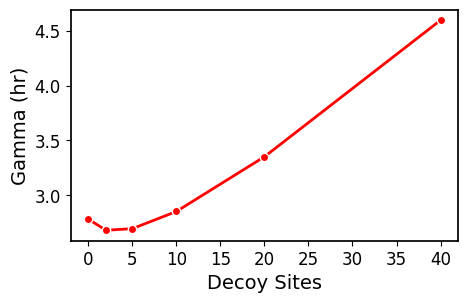

In [10]:

fig, ax = plt.subplots(figsize = (5,3))
ax.plot(metrics_decoy.decoy_sites, metrics_decoy.gamma, "C1o-", mec = '1.0', color = 'red', linewidth = 2)
for i in ['right', 'left', 'top', 'bottom']:
        ax.spines[i].set(linewidth = 1.25)
plt.xlabel('Decoy Sites', fontsize = 14)
plt.ylabel('Gamma (hr)',  fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
#fig.savefig('Figures\sponge_gamma.png', dpi = 400, bbox_inches = 'tight')

## Switching density vs Decoy sites

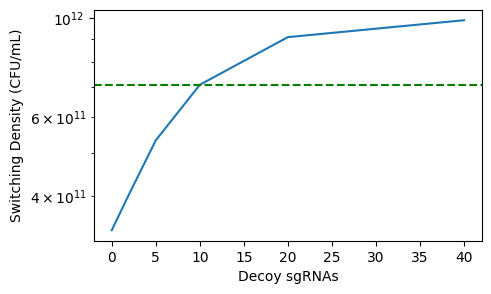

In [9]:
fig, ax = plt.subplots(figsize = (5,3))
ax.plot(metrics_decoy.decoy_sites, metrics_decoy.switching_density)
plt.axhline(y=metrics_decoy.iloc[3].switching_density, color='g', linestyle='--')
ax.set_yscale('log')
plt.xlabel('Decoy sgRNAs')
plt.ylabel('Switching Density (CFU/mL)')
plt.show()
#fig.savefig('Figures\decoy_switching_density.png', dpi = 400, bbox_inches = 'tight')